# Test on real world data

In [1]:
from helper import *
import torch
import torchvision
import torchvision.transforms as transforms
import os

In [2]:
from torchvision.io import read_image, ImageReadMode

In [3]:
dir = "data_pngs"
subjects = {}
for subject in os.listdir(dir):
    for pic in os.listdir(os.path.join(dir, subject)):
        f = os.path.join(dir, subject, pic)
        img = read_image(f, ImageReadMode.GRAY)
        img = torchvision.transforms.ConvertImageDtype(torch.float64)(img)
        img = torch.flatten(img.squeeze().T)
        if subjects.get(subject) == None:
            subjects[subject] = img
        else:
            subjects[subject] = torch.column_stack((subjects[subject], img))

In [4]:
loss, L0, S0 = AccAltProj(subjects['subject01'], 2, 1e-06, torch.tensor(0.7), 20)

In [ ]:
loss

## New functions

In [6]:
def thres(inputs, t, hard=True, old=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))
    else:
        if old:
            out = inputs * (torch.abs(inputs) > t)
        else:
            # out = torch.sign(inputs) * torch.max(\
            #                                     torch.abs(inputs) - torch.nan_to_num(torch.div(torch.pow(t, 6), torch.pow(torch.abs(inputs), 5))) \
            #                                     , torch.zeros(inputs.shape))
            # out = torch.sign(inputs) * torch.max(torch.abs(inputs) \
            #                                     - torch.div(t, torch.exp(3 * torch.div(torch.abs(inputs) - t, t))) \
            #                                     , torch.zeros(inputs.shape))
            # out = inputs * torch.max(1 - torch.div(torch.pow(t, 2), torch.pow(inputs, 2)), torch.zeros(inputs.shape))
            # out = torch.div(1,  1 + torch.exp(-100 * (torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))))) \
            #         + torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape)) \
            #         - t
            # mu = 1.0005 * t
            # out = inputs * (torch.abs(inputs) >= mu) \
            #         + torch.sign(inputs) * (mu/(mu-t))*(torch.abs(inputs) - t) * (mu > torch.abs(inputs)) * (torch.abs(inputs) >= t)
            gamma, beta = 0.95, 1
            out = inputs * (torch.abs(inputs) > torch.sqrt(gamma * beta * t**2)) * (beta <= gamma) \
                    + torch.sign(inputs) * torch.min(beta/(beta - gamma) * torch.max(torch.abs(inputs) - (t * gamma), torch.zeros(inputs.shape)), torch.abs(inputs)) * (beta > gamma)
    return out

In [7]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=True, old=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(0.03))
        # self.coef = nn.Parameter(torch.tensor(1.0))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

In [8]:
def train_nn(net, r, lr, weight_decay, nepochs, dataset):
    torch.autograd.set_detect_anomaly(False)
    params_bftrain = [x.clone().detach().numpy() for x in list(net.parameters())]
    optimizer = Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    l0_norm_of_S_Shat = []
    for epoch in range(nepochs):
        for i in range(len(dataset)):
            L0, S0, M0 = dataset[i]
            optimizer.zero_grad()
            L_hat, S_hat = net(M0, r)
            print(net.err[-1])
            loss = torch.pow(torch.linalg.norm(L0 - L_hat), 2)/ torch.pow(torch.linalg.norm(L0), 2) \
                    + torch.pow(torch.linalg.norm(S0 - S_hat), 2)/ torch.pow(torch.linalg.norm(S0), 2) \
                    #+ torch.pow(torch.linalg.norm(M0 - L_hat - S_hat), 2)
            # loss = torch.linalg.norm(L0 - L_hat)/ torch.linalg.norm(L0) \
            #         + torch.linalg.norm(S0 - S_hat)/ torch.linalg.norm(S0)
            loss.backward()
            optimizer.step()
            l0_norm_of_S_Shat.append(torch.count_nonzero(S0 - S_hat))
            print(list(net.parameters()))
            print(net.gamma.grad, net.beta.grad)
            print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))
    print('Finished Training')
    params_aftrain = [x.clone().detach().numpy() for x in list(net.parameters())]
    return net, params_bftrain, params_aftrain, l0_norm_of_S_Shat

In [9]:
def get_net_outputs(net_trained, net_bftrain, r, dataset):
    out_bftrain = []
    out_hat = []
    for i in range(len(dataset)):
        M_true = dataset[i]
        L_bftrain, S_bftrain = net_bftrain(M_true, r)
        print(net_bftrain.err[-1])
        out_bftrain.append((L_bftrain.detach().numpy(), S_bftrain.detach().numpy()))
        L_hat, S_hat = net_trained(M_true, r)
        print(net_trained.err[-1])
        out_hat.append((L_hat.detach().numpy(), S_hat.detach().numpy()))
    out_bftrain = np.asarray(out_bftrain)
    out_hat = np.asarray(out_hat)
    return out_bftrain, out_hat

In [10]:
def plot_true_vs_est_matrices(L_hat, L_true, S_hat, S_true):
    combined = np.concatenate((L_hat, L_true, S_hat, S_true))
    fig, [ax1, ax2] = plt.subplots(1,2)
    im1 = ax1.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    ax1.set_title("L_hat")
    plt.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(L_true, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    ax2.set_title("L_true")
    plt.colorbar(im2, ax=ax2)
    plt.show()
    fig, [ax3, ax4] = plt.subplots(1,2)
    im3 = ax3.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    ax3.set_title("S_hat")
    plt.colorbar(im3, ax=ax3)
    im4 = ax4.imshow(S_true, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    ax4.set_title("S_true")
    plt.colorbar(im4, ax=ax4)
    plt.show()

## Training

In [11]:
r = 1
max_iter = 50

In [12]:
print("original beta =", 1/(2 * np.power(243 * 320 * 11, 1/4)))

original beta = 0.01644117189829903


In [13]:
train = [subjects[x] for x in ['subject01', 'subject02', 'subject03', 'subject04', 'subject05', 'subject06', 'subject07']]
test = [subjects[x] for x in ['subject08', 'subject09', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject15']]
train_est = []
for i, M_true in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    train_est.append((L0, S0, M_true))
    print(loss[-1])

tensor(1.0181e-08, dtype=torch.float64)
tensor(2.0658e-08, dtype=torch.float64)
tensor(1.5134e-08, dtype=torch.float64)
tensor(1.9481e-08, dtype=torch.float64)
tensor(1.4539e-08, dtype=torch.float64)
tensor(2.3680e-08, dtype=torch.float64)
tensor(9.8958e-09, dtype=torch.float64)


In [14]:
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=5, dataset=train_est)

2.0612961117521244e-08
[Parameter containing:
tensor(0.7200, requires_grad=True), Parameter containing:
tensor(0.0500, requires_grad=True)]
tensor(-0.1894) tensor(-0.3956)
Epoch 1/5 at cost=0.005140770833031897
2.7396298735093934e-07
[Parameter containing:
tensor(0.7088, requires_grad=True), Parameter containing:
tensor(0.0447, requires_grad=True)]
tensor(0.7592) tensor(0.6203)
Epoch 1/5 at cost=0.003526068179898223
7.572828660993914e-08
[Parameter containing:
tensor(0.6966, requires_grad=True), Parameter containing:
tensor(0.0506, requires_grad=True)]
tensor(0.2589) tensor(-0.7209)
Epoch 1/5 at cost=0.02089602629001201
4.3757434572021094e-08
[Parameter containing:
tensor(0.6846, requires_grad=True), Parameter containing:
tensor(0.0529, requires_grad=True)]
tensor(0.1534) tensor(0.2285)
Epoch 1/5 at cost=0.0030649829094197335
1.0186735534002358e-08
[Parameter containing:
tensor(0.6728, requires_grad=True), Parameter containing:
tensor(0.0533, requires_grad=True)]
tensor(0.1374) tensor(

## on train data

In [15]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter), r, train)

2.0612961117521244e-08
1.961984230845795e-13
3.174769997691283e-08
4.118181232276719e-13
3.379746744357647e-08
6.938388738545738e-13
3.6524603524654775e-08
4.1541049818735585e-13
3.0071229460727176e-08
5.734502571476548e-13
3.472429212269612e-08
6.497026517846365e-13
1.9357718041596934e-08
2.889570611695904e-13


In [16]:
out_hat[0][0].shape

(77760, 11)

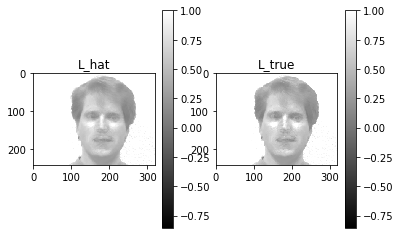

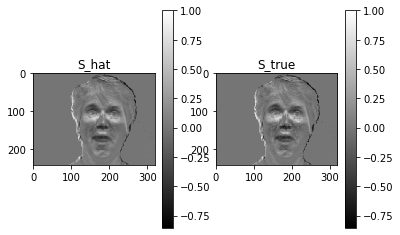

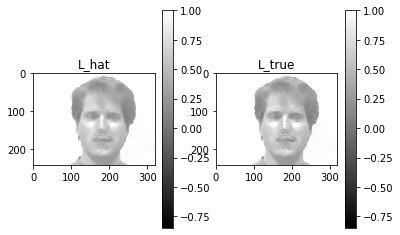

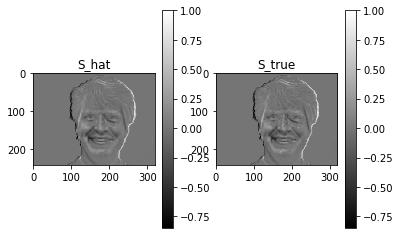

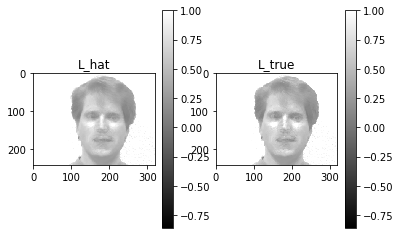

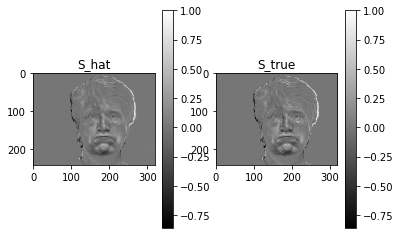

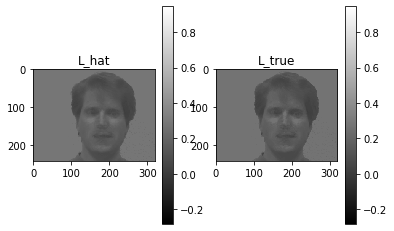

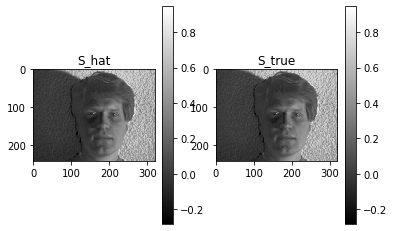

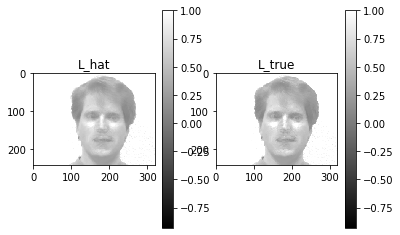

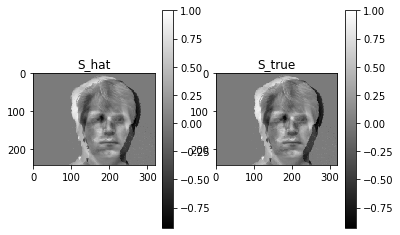

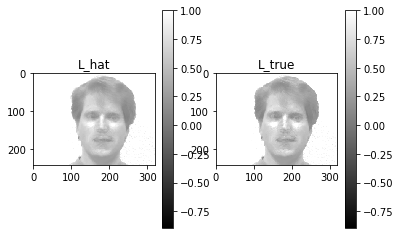

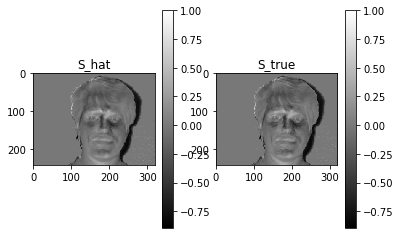

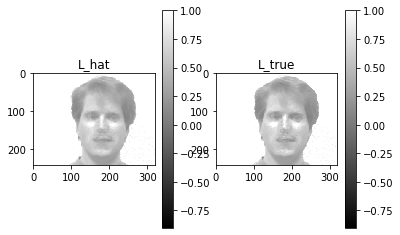

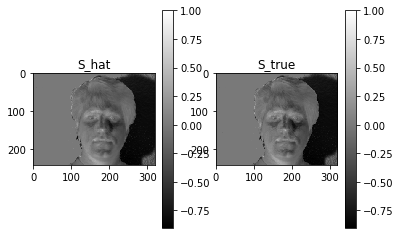

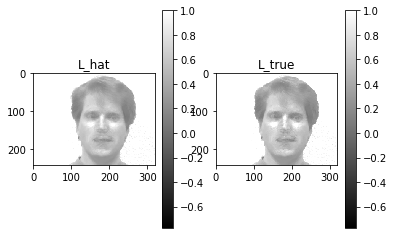

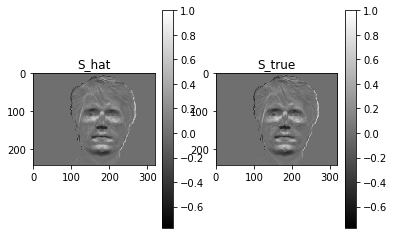

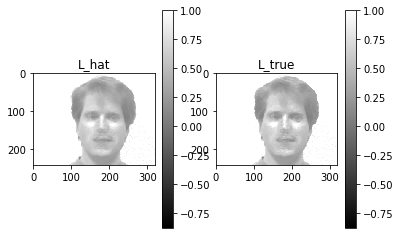

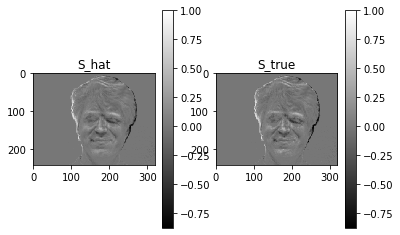

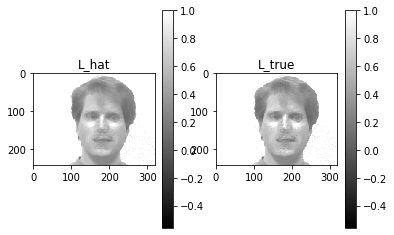

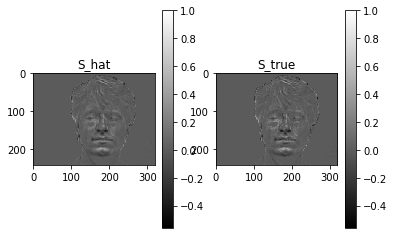

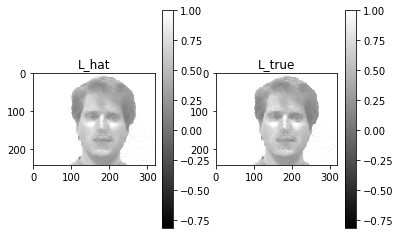

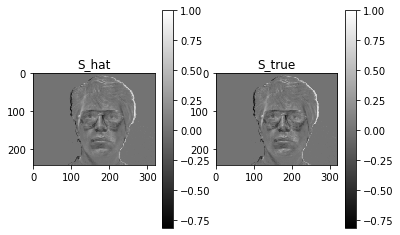

In [17]:
subject1_train_est = train_est[0]
subject1_out_hat = out_hat[0]
lowrank_train_est = subject1_train_est[0]
lowrank_out_hat = subject1_out_hat[0]
sparse_train_est = subject1_train_est[1]
sparse_out_hat = subject1_out_hat[1]
for i in range(11):
    plot_true_vs_est_matrices((lowrank_out_hat[:,i].reshape(320, 243).T) \
                            , (lowrank_train_est[:,i].reshape(320, 243).T) \
                            , (sparse_out_hat[:,i].reshape(320, 243).T) \
                            , (sparse_train_est[:,i].reshape(320, 243).T))

## on test data

In [18]:
out_accaltproj_ontest = []
for i, M_true in enumerate(test):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    print(loss[-1])
    out_accaltproj_ontest.append((L0, S0, M_true))

tensor(8.0928e-09, dtype=torch.float64)
tensor(9.8949e-09, dtype=torch.float64)
tensor(8.9720e-09, dtype=torch.float64)
tensor(6.2974e-09, dtype=torch.float64)
tensor(6.0862e-09, dtype=torch.float64)
tensor(7.5678e-09, dtype=torch.float64)
tensor(1.1220e-08, dtype=torch.float64)
tensor(9.8406e-09, dtype=torch.float64)


In [19]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter), r, test)

1.3923348010659632e-08
2.149208866469518e-12
1.6037300960640718e-08
5.426845995889382e-13
1.9690897359248287e-08
2.4106891030479754e-13
1.5613406550966546e-08
2.950368678099207e-13
1.2744056298733032e-08
6.378877713511786e-13
1.2140990917347729e-08
2.30526076213367e-13
1.9430904061779102e-08
1.339393837570946e-12
1.4969132778947998e-08
2.8442887844537667e-13


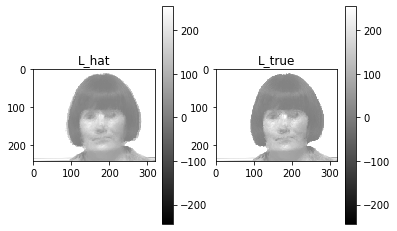

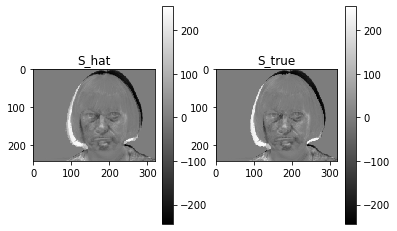

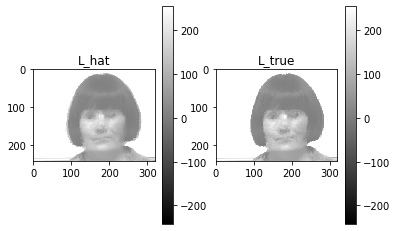

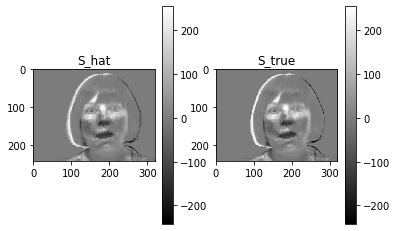

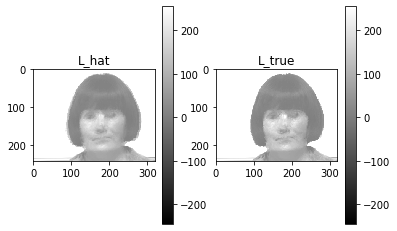

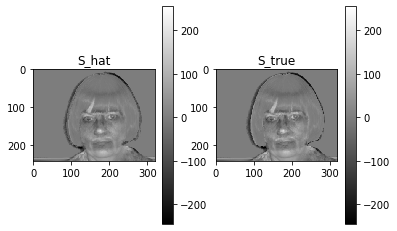

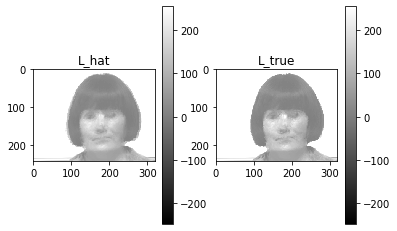

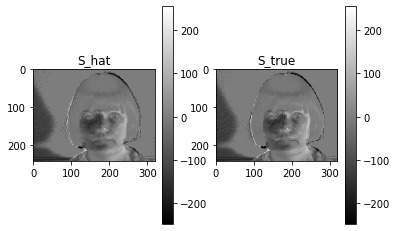

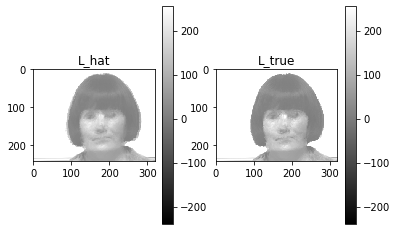

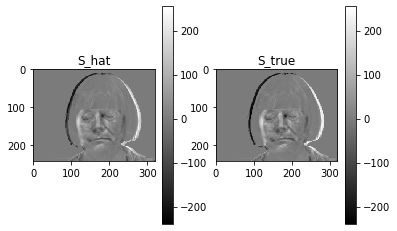

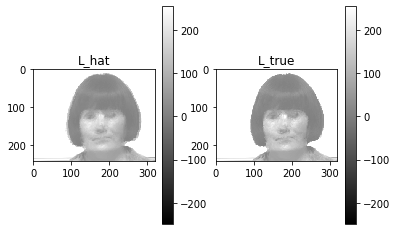

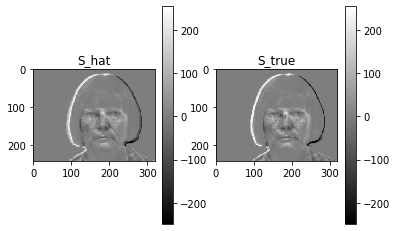

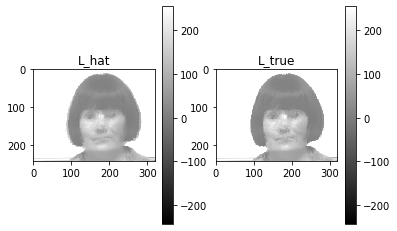

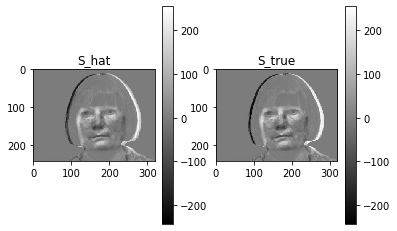

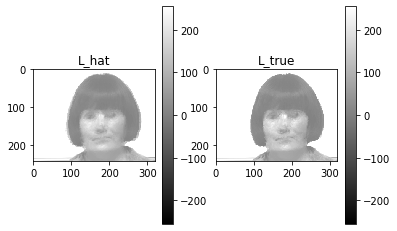

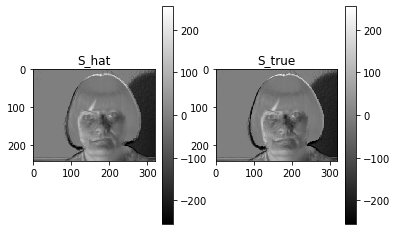

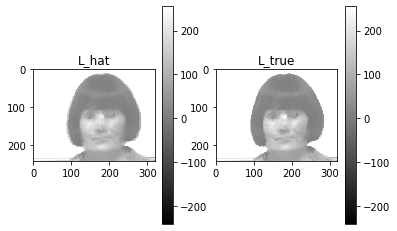

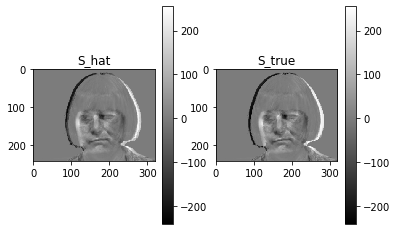

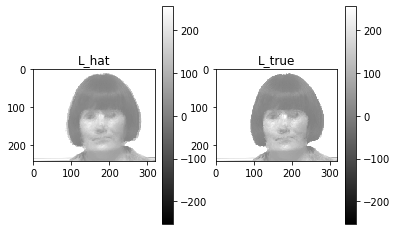

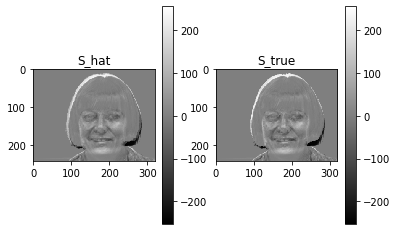

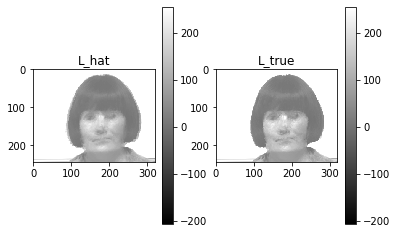

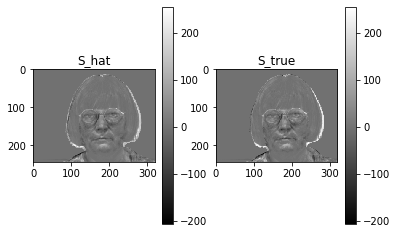

In [23]:
subject1_accaltproj_ontest = out_accaltproj_ontest[3]
subject1_out_hat_ontest = out_hat_ontest[3]
subject1_out_bftrain_ontest = out_bftrain_ontest[3]
lowrank_accaltproj_ontest = subject1_accaltproj_ontest[0]
lowrank_out_hat_ontest = subject1_out_hat_ontest[0]
lowrank_out_bftrain_ontest = subject1_out_bftrain_ontest[0]
sparse_accaltproj_ontest = subject1_accaltproj_ontest[1]
sparse_out_hat_ontest = subject1_out_hat_ontest[1]
sparse_out_bftrain_ontest = subject1_out_bftrain_ontest[1]
for i in range(11):
    plot_true_vs_est_matrices((lowrank_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
                            , (lowrank_accaltproj_ontest[:,i].reshape(320, 243).T * 255) \
                            , (sparse_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
                            , (sparse_accaltproj_ontest[:,i].reshape(320, 243).T * 255))